Use python 3.10 in google colab

In [1]:
!wget https://github.com/korakot/kora/releases/download/v0.10/py310.sh
!bash ./py310.sh -b -f -p /usr/local
!python -m ipykernel install --name "py310" --user

'wget' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


???????? Windows ?????? BIOS ???????

???????? https://aka.ms/wsl2-install

Installed kernelspec py310 in C:\Users\David\AppData\Roaming\jupyter\kernels\py310


In [1]:
import copy

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from typing import Union
from torch.utils.data import Subset
import time
from tqdm import tqdm
from torchvision import transforms, models
from PIL import Image

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

c:\Users\David\anaconda3\envs\speaker-recon\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## SRC: datasets



In [2]:
import os
import torchaudio

def get_dataset(dataset_name, url = None, subset = None):
    """
    Retrieves a dataset and downloads it locally if needed.
        
    Inputs
    ------
    dataset_name : str
        Name of the dataset to download. Allowed dataset names: "librispeech", "librilightlimited", "tedlium"
    
    url : (str, optional)
        Optional argument for some datasets 
    
    subset : (str, optional)
        Optional argument for some datasets 
    
    Returns
    -------
    dataset :
        A torchaudio.dataset
    
    """
    _SAMPLE_DIR = "_assets"
    dataset_name = dataset_name.lower()
    dataset_path = os.path.join(_SAMPLE_DIR, dataset_name)
    os.makedirs(dataset_path, exist_ok=True)
        
    if dataset_name == "librispeech":
        url = url if url else "dev-clean"
        print(f"You're about to download librispeech with url {url}")
        dataset = torchaudio.datasets.LIBRISPEECH(dataset_path, download=True, url=url)
    
    elif dataset_name == "librilightlimited":
        subset = subset if subset else "10min"
        print(f"You're about to download librispeech with subset {subset}")
        dataset = torchaudio.datasets.LibriLightLimited(dataset_path, download=True, subset=subset)
        
    elif dataset_name == "tedlium":
        subset = subset if subset else "train"
        print(f"You're about to download Tedlium with subset {subset}")
        dataset = torchaudio.datasets.TEDLIUM(dataset_path, download=True, subset=subset)
    
    else:
        raise ValueError(f"The dataset you passed '{dataset_name}' is not in the list of datasets")
    
    print("\n Done downloading")
    return dataset 

## SRC: Visualization



In [3]:
#import os
from random import randint

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
#import torchaudio
from IPython.display import Audio, display


#Get a random video clip from dataset
def get_random_sample(dataset):
    """
    Takes a random sample in the dataset and return its waveform and sample rate
    """
    dataset_length = dataset.__len__()
    # get a random sample in the dataset
    sample_id = randint(0, dataset_length)
    (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = dataset.__getitem__(sample_id)
    
    return waveform, sample_rate
    
def plot_mfccs(waveform, sample_rate):
    wv_processed = waveform.numpy().flatten()
    mfccs = librosa.feature.mfcc(y=wv_processed, n_mfcc=13, sr=sample_rate)
    plt.figure(figsize=(15, 8))
    librosa.display.specshow(mfccs, x_axis="time", sr=sample_rate)
    #plt.colorbar(format="%+2.f")
    plt.show()
    
    
    
def play_audio(waveform : torch.Tensor, sample_rate : int) -> None:
    """
    Plays audio given a waveform and sample rate
    
    """
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")
        
def plot_specgram(waveform : torch.Tensor, sample_rate : int , title : str ="Spectrogram", xlim=None) -> None:
    """
    Plots a spectogram of audio given a waveform and sample rate
    """
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)
    
def plot_waveform(waveform, sample_rate, title = "Waveform", xlim = None, ylim = None):
    """
    Plots the waveform of an audio sample
    """
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
    if num_channels > 1:
        axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
        axes[c].set_xlim(xlim)
    if ylim:
        axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)
    
def visualize_random_sample(dataset, play_waveform = True, plot_wave = False, plot_spectogram = False):
    """
    Takes a random sample in the dataset and displays relevant metrics
    """
    dataset_length = dataset.__len__()
    # get a random sample in the dataset
    sample_id = randint(0, dataset_length)
    (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = dataset.__getitem__(sample_id)
    print('waveform: ', waveform)
    print('sample_rate: ', sample_rate)
    print('transcript: ', transcript)
    print('speaker_id: ', speaker_id)
    
    if play_waveform:
        play_audio(waveform, sample_rate)
        
    if plot_wave:
        plot_waveform(waveform, sample_rate)
    
    if plot_spectogram:
        plot_specgram(waveform, sample_rate, title=f"Sample {sample_id}, Speaker_id {speaker_id}")
        
def calculate_statistics(dataset) -> pd.DataFrame:
    """
    Calculates and plots statistics about the dataset
    
    Inputs
    ------
    dataset :
        The dataset to calculate statistics for
        
    verbose : bool
        If true, it will print the statistics
        
    Returns
    -------
    df_info : pd.DataFrame
        A dataframe with statistics about the dataset. Can be used to make your own statistics
    """
    print(f"Dataset has {dataset.__len__()} samples")
    print(f"Random samples has shape: {dataset.__getitem__(0)[0].shape}")
    
    waveform_lengths = []
    sample_rates = []
    transcript_lengths = []
    speaker_ids = []
    audio_durations = []    
    
    for i in range(dataset.__len__()):
        (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = dataset.__getitem__(i)
        waveform_lengths.append(waveform[0].shape[0])
        sample_rates.append(sample_rate)
        transcript_lengths.append(len(transcript))
        speaker_ids.append(speaker_id)
        
        num_channels, num_frames = waveform.shape
        duration = num_frames / sample_rate
        audio_durations.append(duration)
        
    dataset_stats = pd.DataFrame.from_dict(
    {
        "waveform_lengths" : waveform_lengths,
        "sample_rates" : sample_rates,
        "transcript_lengths" : transcript_lengths,
        "audio_durations" : audio_durations,
    }
    )
    
    print(f"Unique speaker ids: {len(np.unique(speaker_ids))}")
    display(dataset_stats.describe().loc[["min","std","min","max"]].round())
    print("\n")
    
    # plotting:
    fig, ax = plt.subplots(1, dataset_stats.shape[1], figsize=(12, 6))
    for i, col in enumerate(dataset_stats.columns):
        ax[i].boxplot(dataset_stats[col])
        ax[i].set_title(col)
    plt.tight_layout()
    
    plt.figure(figsize=(6, 6))
    plt.scatter(dataset_stats["waveform_lengths"], dataset_stats["transcript_lengths"])
    plt.xlabel("waveform_lengths")
    plt.ylabel("transcript_lengths")
    
    return dataset_stats

## SRC: Audio_utils





In [4]:
from typing import Union

import numpy as np
import numpy.typing as npt
import pandas as pd
from tqdm import tqdm


def split_waveform(waveform, window_size):
    """
    Takes an original waveform and reduce to chunks of smaller intervals using a sliding window
    
    waveform : nd.array
    
    window_size : int
        window size in seconds
    
    Returns
    -------
    splitted_waveform : list[nd.array]
        list of waveforms
    
    """
    splitted_waveform = []
    
    for i in range(0, len(waveform), window_size):
        split = waveform[i:i+window_size]
        if len(split) == window_size:
            splitted_waveform.append(split)

    return splitted_waveform

class CepstralNormalization:
    def __init__(self, number_spectral_coefficients : int):
        """
        Class for Cepstral Normalization. Cepstral normalization performs normalization
        by channels/coefficients
        """
        self.number_spectral_coefficients = number_spectral_coefficients
        self.mfcc_mean : list[float] = []
        self.mfcc_std : list[float] = []
    
    def fit(self, mfcc_ids, mfcc_channel_db):
        """
        Calculates the mean and standard deviation of each channel of the MFCCs
        
        Inputs
        ------
        mfcc_ids : list[int]
            list of the mfcc ids to use for fitting

        mfcc_channel_db : pd.DataFrame
            A dataframe of the following shape

                    channel_1 | channel 2 | channel 3 | ...
            mfcc_id

        Returns
        -------
        mfcc_mean : list[float]
            A list with the mean value of each channel
        
        mfcc_std : list[float]
            A list with the standard deviation value of each channel

        """
        mfcc_mean = []
        mfcc_std = []
        
        print('Normalizing...')
        for channel in tqdm(range(self.number_spectral_coefficients)):
            channel_data = mfcc_channel_db.loc[mfcc_ids][f"channel_{channel}"].values
            channel_data_list = []
            for x in channel_data:
                channel_data_list.extend(x.flatten().tolist())
            
            mfcc_mean.append(np.mean(channel_data_list))
            mfcc_std.append(np.std(channel_data_list))

        self.mfcc_mean, self.mfcc_std = mfcc_mean, mfcc_std
        
        return self.mfcc_mean, self.mfcc_std
    
    def transform(self, mfcc_ids, mfcc_channel_db):
        """
        Normalizes MFCCs

        Inputs
        ------
        mfcc_ids : list[int]
            list of the mfcc ids to normalize

        mfcc_channel_db : pd.DataFrame
            A dataframe of the following shape

                    channel_1 | channel 2 | channel 3 | ...
            mfcc_id

        Returns
        -------
        mfcc_channel_db : pd.DataFrame
            normalized dataframe

        """                
        normalized_mfcc_channel_db = pd.DataFrame(data=mfcc_ids, columns=['mfcc_id']).set_index('mfcc_id')

        for channel in range(self.number_spectral_coefficients):
            channel_data = mfcc_channel_db.loc[mfcc_ids][f"channel_{channel}"].values
            channel_data = (channel_data - self.mfcc_mean[channel]) / self.mfcc_std[channel]
            normalized_mfcc_channel_db[f"channel_{channel}"] = channel_data
            
        return normalized_mfcc_channel_db

    def inverse_transform(self):
        #TODO
        raise NotImplementedError

## Problem Definition: Speaker Classification

Our project consists of identifying a speaker based on recorded audio samples. The model is trained from multiple audio samples for many speakers. Given a new audio sample, the model should identify which of the speakers it belongs to.  

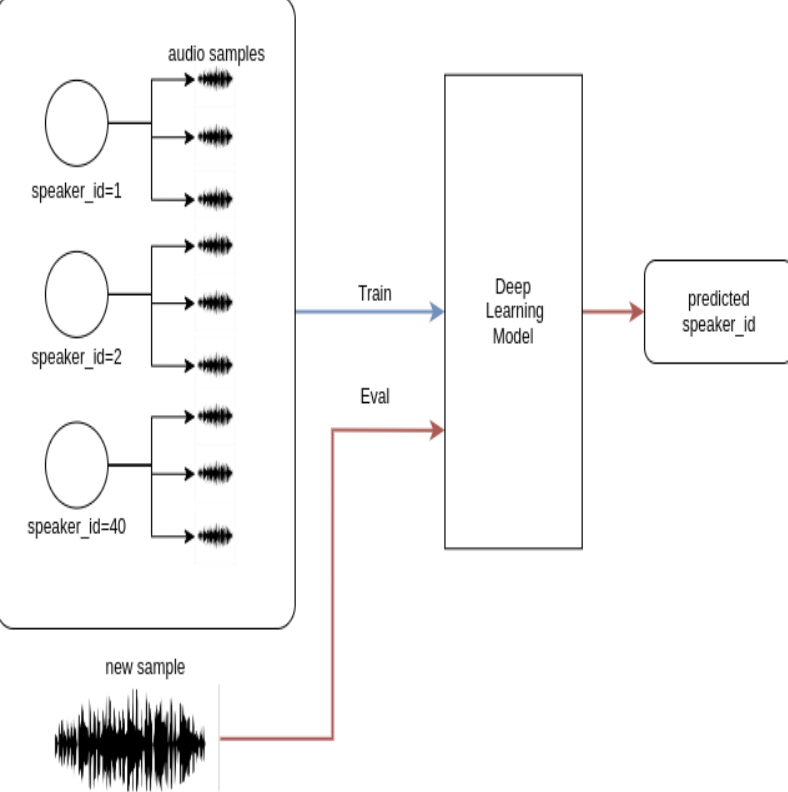

## Dataset
There are multiple datasets that include speaker_id and audio samples. Up to this point, we decided to start with Librispeech as it provides hours of recorded audio samples in relatively noise-free environments. 

LIBRISPEECH
LibriSpeech is a corpus of approximately 1000 hours of 16kHz read English speech, prepared by Vassil Panayotov with the assistance of Daniel Povey. The data is derived from read audiobooks from the LibriVox project, and has been carefully segmented and aligned.

There are multiple sizes of the dataset. In this notebook we are using **dev-clean** which is the development dataset. In other notebooks, we will use a version with more samples 

In [5]:
dataset_name = "librispeech"
url = 'train-clean-100'
dataset = get_dataset(dataset_name, url=url)

You're about to download librispeech with url train-clean-100

 Done downloading


# Data Visualization

The data extract from librispeech includes audio samples recorded as waveforms. In audio processing algorithm, it is standard practice to extract data by transforming the waveforms into a spectrogram or a varation of a spectrogram called a Mel-frequency cepstrum (MFC). This is done to remove unnecessary data from the waveforms and keep important information such as time, frequency, and amplitude.   

Visualizing data in random sample from the dataset

waveform:  tensor([[ 0.0021,  0.0035,  0.0025,  ...,  0.0020, -0.0013, -0.0044]])
sample_rate:  16000
transcript:  THAT THE ONLY WAY YOU CAN MERIT YOUR LOVER MUST BE BY DINT OF INDUSTRY AND DILIGENCE I WILL MAKE TRIAL OF YOUR HOUSEWIFERY THEN SHE ORDERED PSYCHE TO BE LED TO THE STOREHOUSE OF HER TEMPLE
speaker_id:  2910


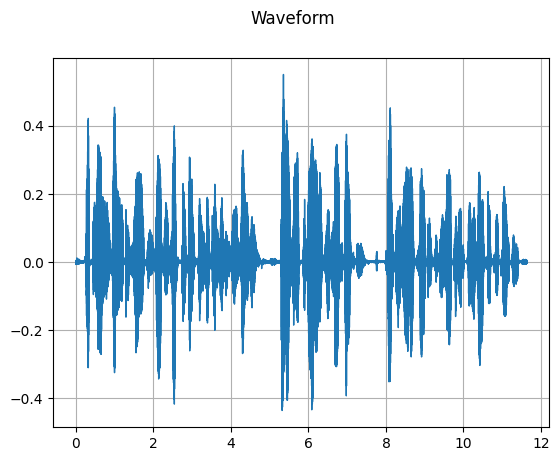

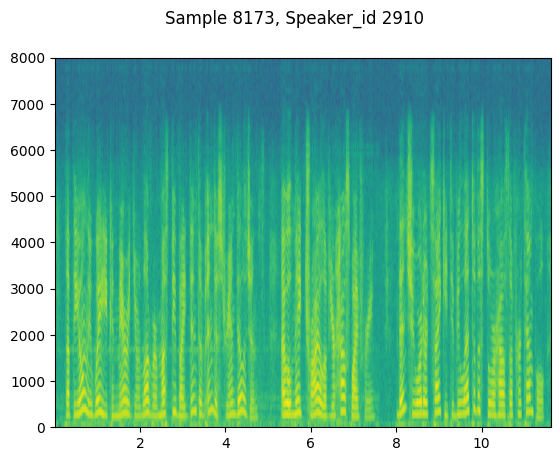

In [6]:
visualize_random_sample(dataset, plot_wave=True, plot_spectogram=True)

#### Calculate statistics in dataset

In [7]:
waveform_lengths = []
sample_rates = []
transcript_lengths = []
speaker_ids = []
audio_durations = []
waveforms = []
transcripts = []

for i in tqdm(range(dataset.__len__())):
    (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = dataset.__getitem__(i)
    speaker_ids.append(speaker_id)

    waveform_lengths.append(waveform[0].shape[0])
    sample_rates.append(sample_rate)
    transcript_lengths.append(len(transcript))
    waveforms.append(waveform[0].numpy())
    transcripts.append(transcript)
    num_channels, num_frames = waveform.shape
    duration = num_frames / sample_rate
    audio_durations.append(duration)

dataset_stats = pd.DataFrame.from_dict(
{
    "waveform_lengths" : waveform_lengths,
    "sample_rates" : sample_rates,
    "transcript_lengths" : transcript_lengths,
    "audio_durations" : audio_durations,
}
    )

100%|██████████| 28539/28539 [03:22<00:00, 140.90it/s]


Dataset has 28539 samples
Random samples has shape: torch.Size([1, 225360])
Unique speaker ids: 251


waveform_lengths  sample_rates  transcript_lengths  audio_durations
min           22560.0       16000.0                 8.0              1.0
std           57194.0           0.0                59.0              4.0
min           22560.0       16000.0                 8.0              1.0
max          392400.0       16000.0               398.0             25.0

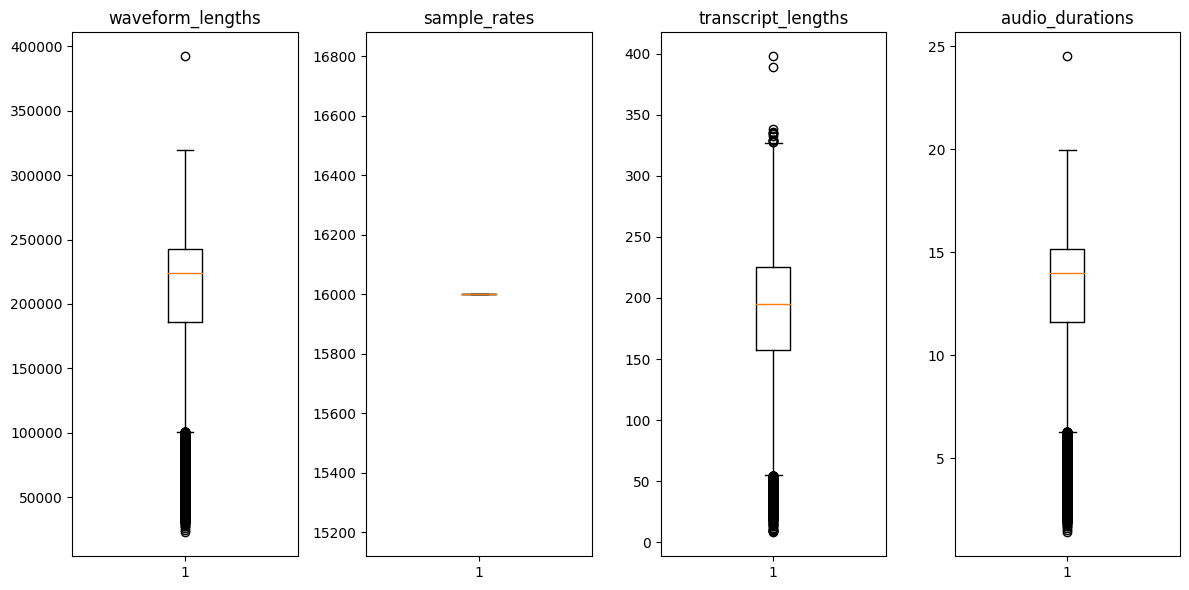

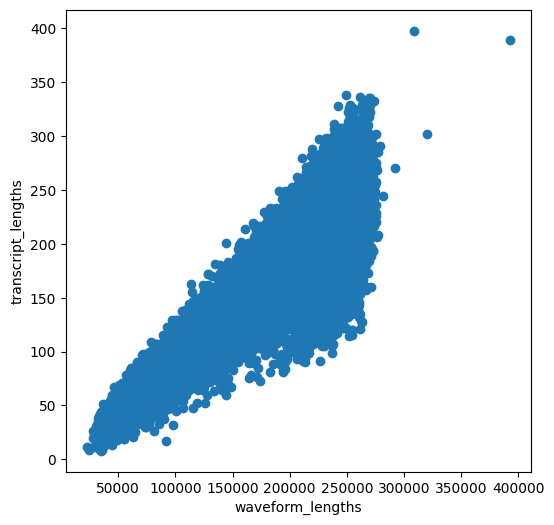

In [8]:
df = calculate_statistics(dataset)

We can see from the above charts that there is a lot of variance in the audio duration. Our model needs to take consistent sizes of audio.

In [9]:
df_spkr = pd.DataFrame(columns=['speaker_id', 'duration'])
df_spkr['speaker_id'] = speaker_ids
df_spkr['duration'] = audio_durations

In [10]:
df_spkr.to_csv('df_speaker_ids.csv')
df_spkr = pd.read_csv('df_speaker_ids.csv')

In [11]:
df_spkr.groupby('speaker_id').mean().sort_values(by='duration', ascending=True)

Unnamed: 0   duration
speaker_id                       
27              7391.5   8.756087
1183            1016.5   8.832955
211             5090.5   9.115632
4014           12577.0   9.164455
730            23220.0   9.388261
...                ...        ...
412            13299.0  14.137790
7517           24081.0  14.148641
2092            4954.5  14.206226
8312           26264.5  14.231651
7794           24413.5  14.279811

[251 rows x 2 columns]

Because on average the duration of each speaker is 4.8 or higher, we decided to use a window_size of 4 seconds. Samples shorter than 4 seconds will be removed from the dataset.

Number of samples for each speaker

In [12]:
df_spkr.groupby('speaker_id').size().sort_values()

speaker_id
7312     26
1992     56
445      60
1183     66
8014     76
       ... 
2989    155
8063    155
730     161
4014    165
211     166
Length: 251, dtype: int64

We can see than in this dataset, some speakers have 36 samples only. This could potentially be little data to train a model. 

Unique speaker ids

In [13]:
np.unique(df_spkr['speaker_id'])

array([  19,   26,   27,   32,   39,   40,   60,   78,   83,   87,   89,
        103,  118,  125,  150,  163,  196,  198,  200,  201,  211,  226,
        229,  233,  248,  250,  254,  289,  298,  302,  307,  311,  322,
        328,  332,  374,  403,  405,  412,  426,  441,  445,  446,  458,
        460,  481,  587,  625,  669,  696,  730,  831,  839,  887,  909,
        911, 1034, 1040, 1069, 1081, 1088, 1098, 1116, 1183, 1235, 1246,
       1263, 1334, 1355, 1363, 1447, 1455, 1502, 1553, 1578, 1594, 1624,
       1723, 1737, 1743, 1841, 1867, 1898, 1926, 1963, 1970, 1992, 2002,
       2007, 2092, 2136, 2159, 2182, 2196, 2289, 2384, 2391, 2416, 2436,
       2514, 2518, 2691, 2764, 2817, 2836, 2843, 2893, 2910, 2911, 2952,
       2989, 3112, 3168, 3214, 3235, 3240, 3242, 3259, 3374, 3436, 3440,
       3486, 3526, 3607, 3664, 3699, 3723, 3807, 3830, 3857, 3879, 3947,
       3982, 3983, 4014, 4018, 4051, 4088, 4137, 4160, 4195, 4214, 4267,
       4297, 4340, 4362, 4397, 4406, 4441, 4481, 46

Visualize spectrograms

In [14]:
df_speaker_waveform = pd.DataFrame(columns=['speaker_id', 'waveform', 'transcript'])
df_speaker_waveform['speaker_id'] = speaker_ids
df_speaker_waveform['waveform'] = waveforms
df_speaker_waveform['transcript'] = transcripts

In [15]:
df_speaker_waveform[df_speaker_waveform['speaker_id']==84].head()

Empty DataFrame
Columns: [speaker_id, waveform, transcript]
Index: []

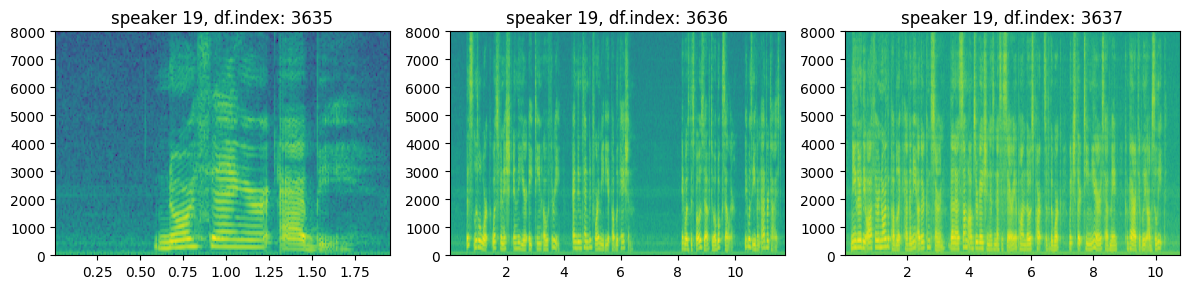

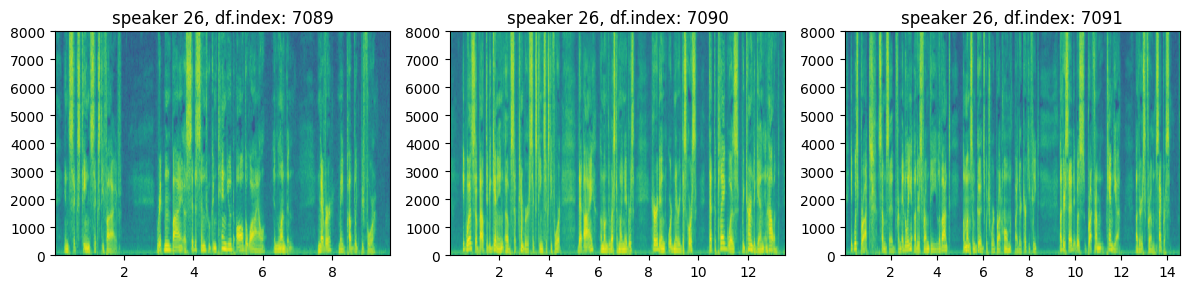

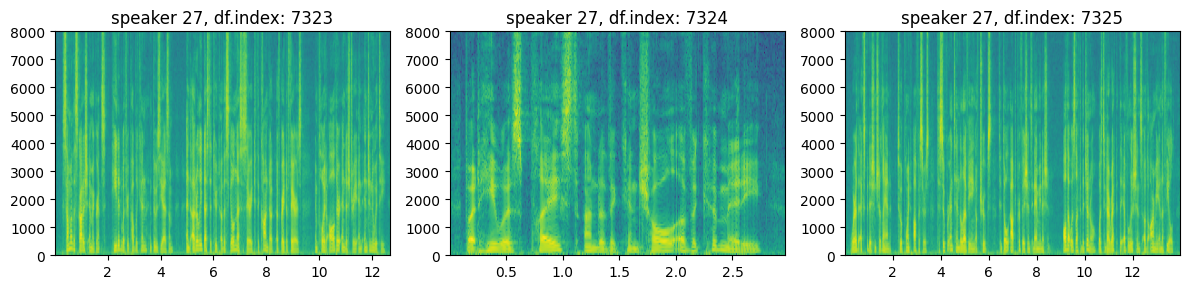

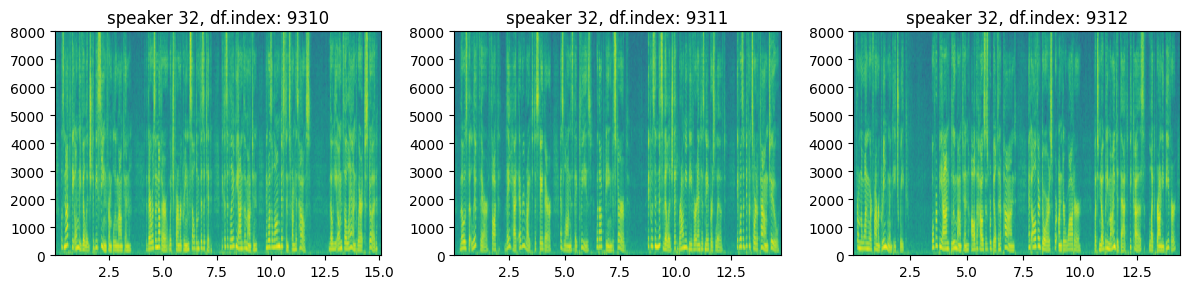

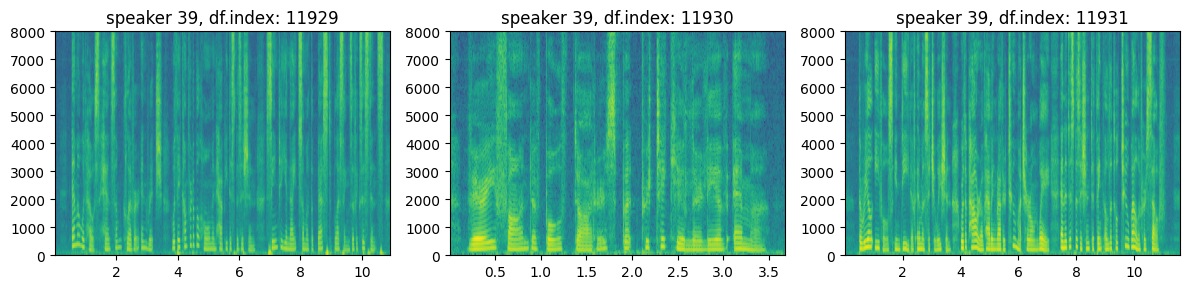

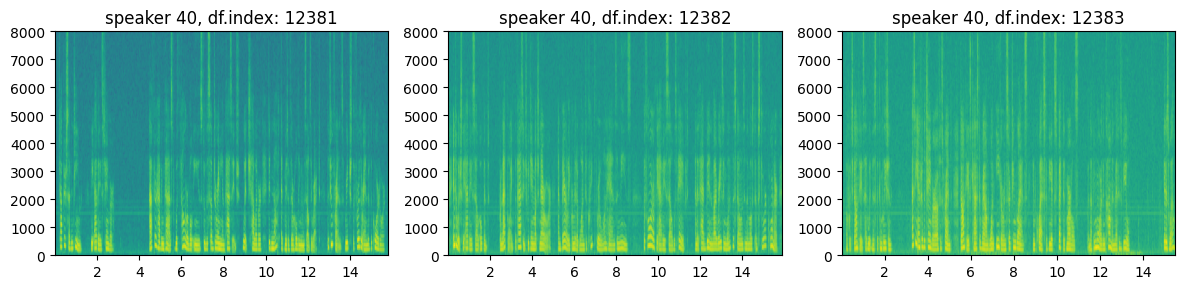

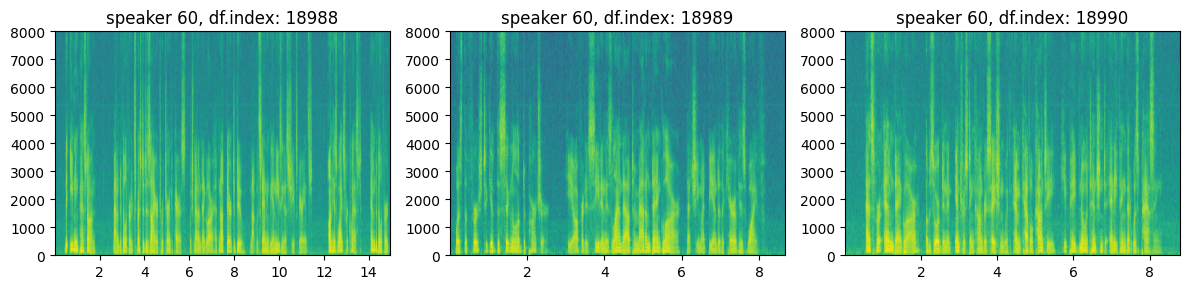

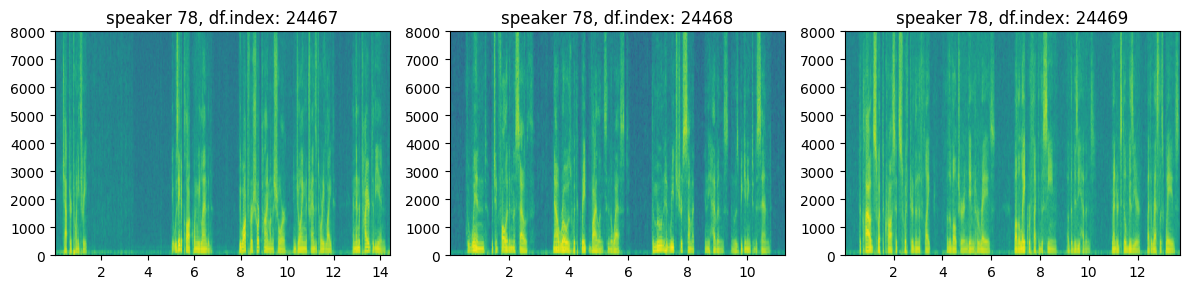

In [16]:
num_cols = 3
for speaker_id in np.unique(df_speaker_waveform['speaker_id'])[:8]:
    fig, ax = plt.subplots(1, num_cols, figsize=(12, 3))
    waves = df_speaker_waveform[df_speaker_waveform['speaker_id']==speaker_id]['waveform'].values
    idx = df_speaker_waveform[df_speaker_waveform['speaker_id']==speaker_id]['waveform'].index
    for j, wave in enumerate(waves[:num_cols]):
        ax[j].specgram(wave, Fs=sample_rate)
        ax[j].set_title(f'speaker {speaker_id}, df.index: {idx[j]}')

        plt.tight_layout()

Visualize MFCC spectrograms

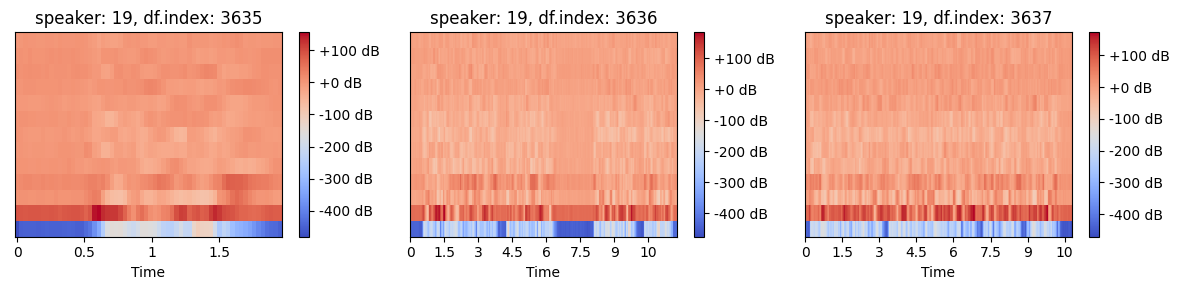

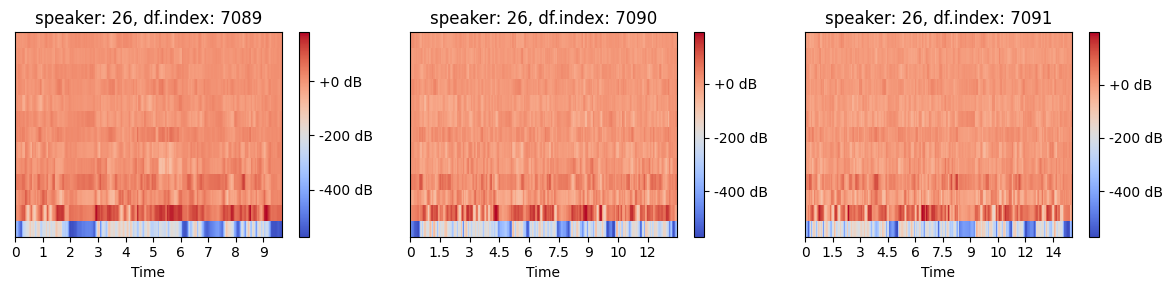

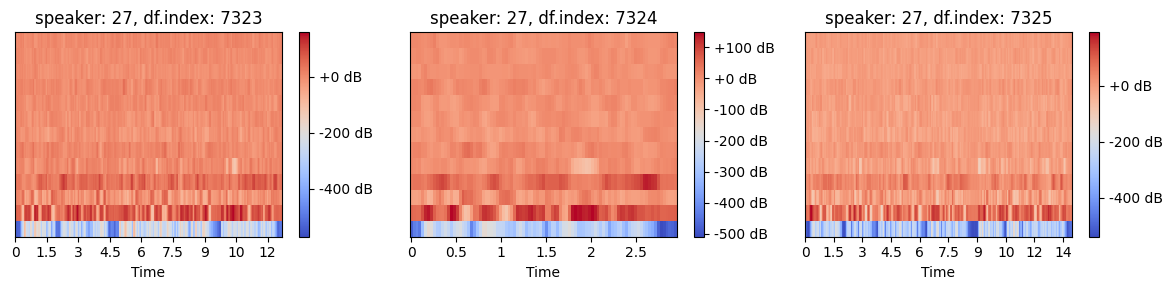

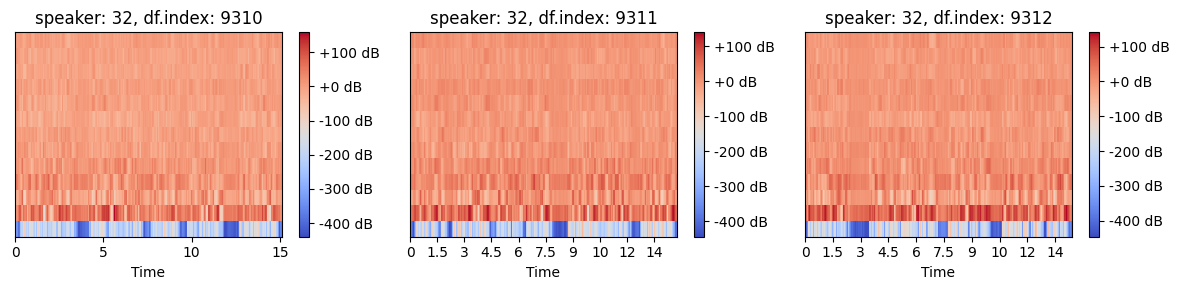

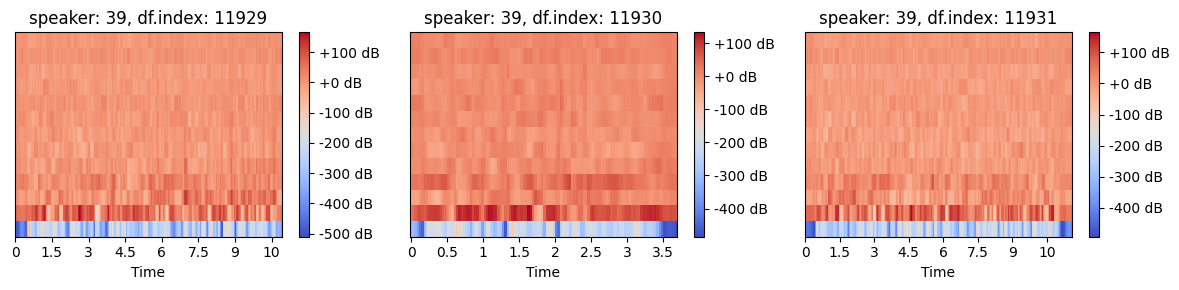

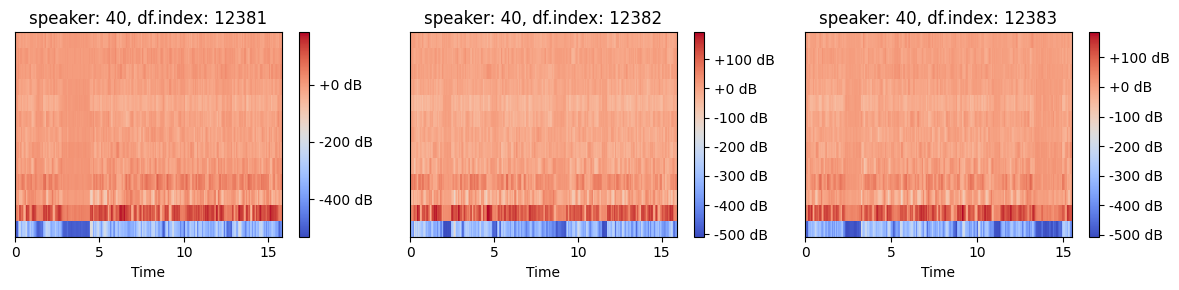

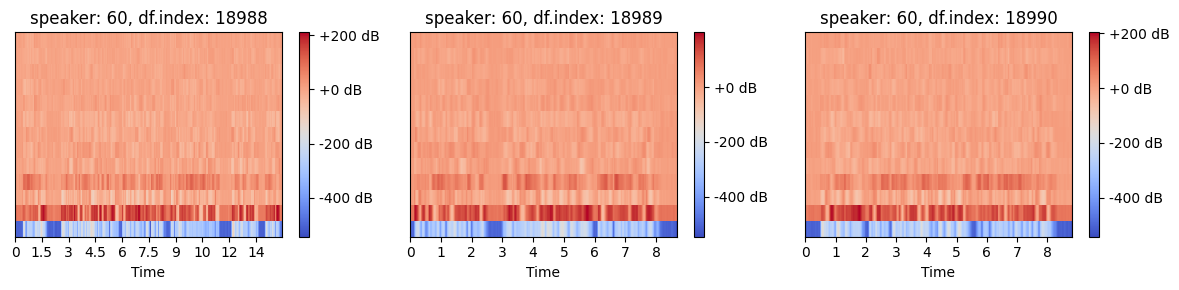

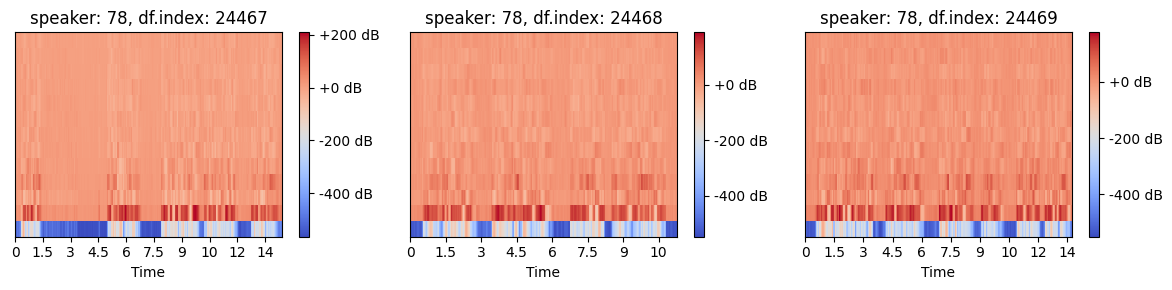

In [17]:
num_cols = 3
for speaker_id in np.unique(df_speaker_waveform['speaker_id'])[:8]:
    fig, ax = plt.subplots(1, num_cols, figsize=(12, 3))
    waves = df_speaker_waveform[df_speaker_waveform['speaker_id']==speaker_id]['waveform'].values
    idx = df_speaker_waveform[df_speaker_waveform['speaker_id']==speaker_id]['waveform'].index
    for j, wave in enumerate(waves[:num_cols]):
        mfccs = librosa.feature.mfcc(y=wave.flatten(), n_mfcc=13, sr=sample_rate)
        img = librosa.display.specshow(mfccs, x_axis="time", sr=sample_rate, ax=ax[j])
        ax[j].set_title(f'speaker: {speaker_id}, df.index: {idx[j]}')
        fig.colorbar(img, ax=ax[j], format="%+2.f dB")
    plt.tight_layout()

Visualization of each channel in MFCC

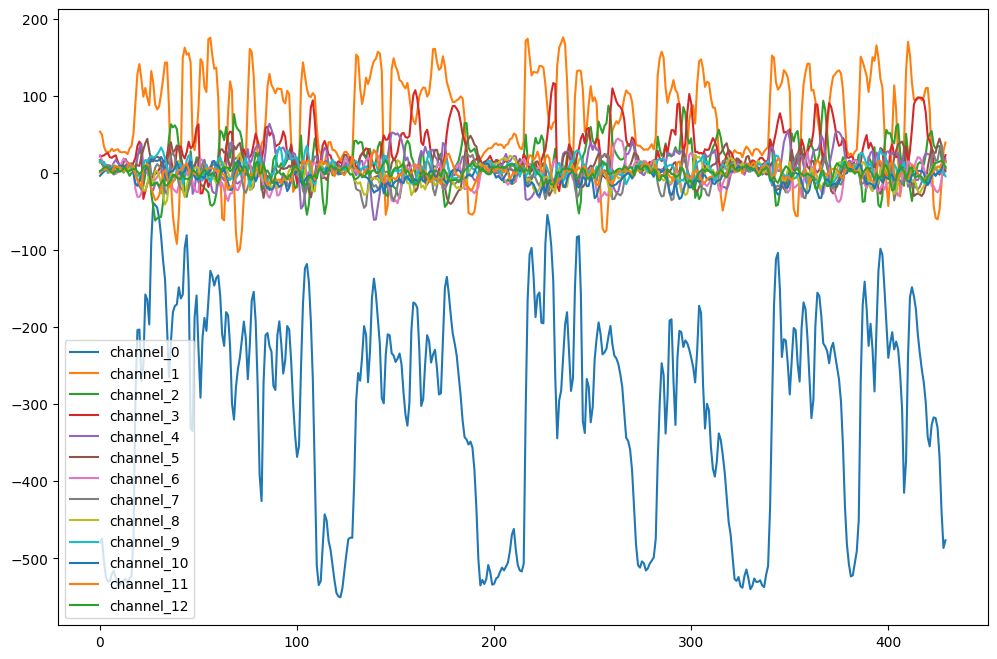

In [19]:
plt.figure(figsize=(12, 8))
for i in range(mfccs.shape[0]):
    plt.plot(mfccs[i,:], label=f"channel_{i}")
plt.legend()

## Preprocessing

<center><img src="images/preprocessing.png" height="400"></center>

The preprocessing pipeline consists of the following steps:
1. Transform waveforms to MFCC
2. (optional) Perform Cepstral Normalization on the MFCC
3. Transform MFCC (2D-array) to a greyscale image

**Cepstral normalization** is the process of normalizing the MFCCs at every channel. The first channels of the MFCC carry the most important features; therefore, channels should not be mixed during normalization. At every channel, the values are normalized by subtracting the mean and dividing by the standard deviation: 
$$(X_{channel} - \mu_{channel})/\sigma_{channel} $$

Special consideration had to be taken during splitting of the data into train, validation, and test as well as during normalization. 

1. To ensure that each speaker_id is represent in each set, before splitting the audio samples were grouped by speaker id. Then the samples in each speaker_id are splitted in x% train, y% validation, z% test

2. To ensure there is no data leakage between training and other sets during normalization, **the Cepstral Normalizer only uses MFCCs from the training set during fitting.**

In [18]:
class MFCCData(Dataset):
    def __init__(self, speaker_mfcc_db, mfcc_channel_db, transform=None):
        """
        Creates a dataset of spectrograms from a dataset of waveforms
        
        Inputs
        ------
        speaker_mfcc_db : pd.DataFrame
            dataframe of (index, speaker_id, mfcc_id)
            
        mfcc_channel_db : pd.DataFrame
            dataframe of (mfcc_id, channel_1, channel_2, ...)
            
        transform : optional 
            transformations to perform on the MFCCs
        """
        self.speaker_mfcc_db = speaker_mfcc_db
        self.mfcc_channel_db = mfcc_channel_db        
        self.transform = transform
            
    def __len__(self):
        return len(self.speaker_mfcc_db)

    def __getitem__(self, idx):
        speaker_id = self.speaker_mfcc_db.iloc[idx]['speaker_id']
        mfcc_id = self.speaker_mfcc_db.iloc[idx]['mfcc_id']
        
        mfcc = []
        for i, col in enumerate(self.mfcc_channel_db.columns):
            mfcc_channel_i = self.mfcc_channel_db.loc[mfcc_id, f'channel_{i}']
            mfcc.append(mfcc_channel_i)
            
        mfcc = np.asarray(mfcc)
        mfcc = mfcc.reshape(len(self.mfcc_channel_db.columns), -1)
        
        if self.transform:
            mfcc = mfcc.reshape(1, mfcc.shape[0], mfcc.shape[1])
            mfcc = np.transpose(mfcc, [1, 2, 0])
            mfcc = self.transform(mfcc)
            
        else:
            mfcc = mfcc.reshape(1, mfcc.shape[0], mfcc.shape[1])
            
        speaker_id = torch.tensor(speaker_id) 
        mfcc = torch.tensor(mfcc) 
            
        if torch.cuda.is_available():
            speaker_id = speaker_id.to('cuda')
            mfcc = mfcc.to('cuda')
            
        return mfcc, speaker_id

In [19]:
def speaker_encoder(speaker_ids):
    """
    Creates a dictionary of (speaker_id, encoded_id) pairs
    """
    speaker_dict = {}
    for i, speaker_id in enumerate(speaker_ids):
        speaker_dict[speaker_id] = i
    return speaker_dict

In [20]:
def create_mfcc_databases(dataset, window_size, sample_rate, speaker_dict, number_spectral_coefficients):
    """
    Creates two databases from an audio dataset e.g. librispeech
    
    Inputs
    -----
    
    base_dataset : 
        A pytorch audio dataset like librispeech
    
    window_size : int
        window size to be used to consistently split waveforms

    sample_rate : int
        sample rate in kHz    
    
    speaker_dict : dict
        dictionary of {'speaker_id':encoded_id} pairs          

    number_spectral_coefficients : int
        number of spectral coefficients to keep for the MFCC calculation
        
    Returns
    -------
    speaker_mfcc_db : pd.DataFrame 
        df with shape (index_id, speaker_id, mfcc_id)
    
    mfcc_channel_db : pd.DataFrame
        df with shape (mfcc_id, channel_id)
    
    """
    try:
        speaker_mfcc_db = pd.read_pickle(f'speaker_mfcc_db_{window_size}_{sample_rate}_{number_spectral_coefficients}.pkl')
        mfcc_channel_db = pd.read_pickle(f'mfcc_channel_db_{window_size}_{sample_rate}_{number_spectral_coefficients}.pkl')
    
    except FileNotFoundError:
        speaker_mfcc_db = pd.DataFrame(columns=["speaker_id", "mfcc_id"])
        mfcc_channel_db = pd.DataFrame(columns=["mfcc_id"]+[f"channel_{i}" for i in range(number_spectral_coefficients)]).set_index('mfcc_id')

        idx = 0

        print('Creating a database. Hold tight...')
        for i in tqdm(range(dataset.__len__())):
            (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = dataset.__getitem__(i)
            waveform_arr = waveform.numpy().flatten()
            splitted_waveform = split_waveform(waveform_arr, window_size) # split waveforms into consistent chunks

            for chunk in splitted_waveform: # transform waveforms into MFCC spectrograms
                mfccs = librosa.feature.mfcc(y=chunk.flatten(), n_mfcc=13, sr=sample_rate)

                speaker_mfcc_db.loc[idx, "speaker_id"] = speaker_dict[speaker_id]
                speaker_mfcc_db.loc[idx, "mfcc_id"] = idx

                for j in range(number_spectral_coefficients):
                    mfcc_channel_db.loc[idx, f"channel_{j}"] = 1
                    mfcc_channel_db.at[idx, f"channel_{j}"] = mfccs[j, :]
                
                idx += 1

        speaker_mfcc_db.to_pickle(f'speaker_mfcc_db_{window_size}_{sample_rate}_{number_spectral_coefficients}.pkl')
        mfcc_channel_db.to_pickle(f'mfcc_channel_db_{window_size}_{sample_rate}_{number_spectral_coefficients}.pkl')

    return speaker_mfcc_db, mfcc_channel_db

In [21]:
def split_train_test_val(speaker_mfcc_db, train_pct, val_pct, 
                         test_pct):
    """
    Splits the dataset into train, validation, and test. This function returns the indices of the dataframe corresponding
    to each set
    """
    train_ids = []
    val_ids = []
    test_ids = []
    
    for speaker_id in np.unique(speaker_mfcc_db["speaker_id"].values):
        mfcc_ids = speaker_mfcc_db[speaker_mfcc_db["speaker_id"]==speaker_id]["mfcc_id"].sample(frac=1).tolist()
        len_ids = len(mfcc_ids)
        
        train_ids.extend(mfcc_ids[:int(len_ids * train_pct)])
        val_ids.extend(mfcc_ids[int(len_ids * train_pct):int(len_ids * (train_pct + val_pct))])
        test_ids.extend(mfcc_ids[int(len_ids * (train_pct + val_pct)):])
    
    return train_ids, val_ids, test_ids

In [22]:
def get_datasets(base_dataset, speaker_dict, window_size, sample_rate , train_pct , 
                 val_pct , test_pct , number_spectral_coefficients , cepstral_normalize , 
                 transform=None):
    """
    Wrapper around other functions to create datasets
    
    Inputs
    -----
    
    base_dataset : 
        A pytorch audio dataset like librispeech
    
    speaker_dict : dict
        dictionary of {'speaker_id':encoded_id} pairs          

    window_size : int
        window size to be used to consistently split waveforms

    sample_rate : int
        sample rate in kHz

    train_pct : float
        train percentage
    
    val_pct : float
        validation percentage

    test_pct : float
        Test percentage

    number_spectral_coefficients : int
        number of spectral coefficients to keep for the MFCC calculation
        
    normalize : bool
        whether to apply cepstral normalization
        
    transform : 
        a custom transformation to apply to the dataset
        
    Returns
    -------
    
    mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test
    
    """
    speaker_mfcc_db, mfcc_channel_db = create_mfcc_databases(base_dataset, window_size=window_size, sample_rate=sample_rate, speaker_dict=speaker_dict, number_spectral_coefficients=number_spectral_coefficients)

    train_ids, val_ids, test_ids = split_train_test_val(speaker_mfcc_db, train_pct, val_pct, test_pct)
    
    speaker_mfcc_db_train = speaker_mfcc_db.loc[train_ids]
    speaker_mfcc_db_val = speaker_mfcc_db.loc[val_ids]
    speaker_mfcc_db_test = speaker_mfcc_db.loc[test_ids]
    
    if cepstral_normalize:
        cepstral_normalization = CepstralNormalization(number_spectral_coefficients)
        cepstral_normalization.fit(speaker_mfcc_db_train['mfcc_id'].values, mfcc_channel_db)
        normalized_mfcc_channel_db_train = cepstral_normalization.transform(speaker_mfcc_db_train['mfcc_id'].values, mfcc_channel_db)
        normalized_mfcc_channel_db_val = cepstral_normalization.transform(speaker_mfcc_db_val['mfcc_id'].values, mfcc_channel_db)
        normalized_mfcc_channel_db_test = cepstral_normalization.transform(speaker_mfcc_db_test['mfcc_id'].values, mfcc_channel_db)
        mfcc_channel_db = pd.concat([normalized_mfcc_channel_db_train, normalized_mfcc_channel_db_val, normalized_mfcc_channel_db_test])
        
    mfcc_channel_db_train = mfcc_channel_db.loc[speaker_mfcc_db_train['mfcc_id'].values]
    mfcc_channel_db_val = mfcc_channel_db.loc[speaker_mfcc_db_val['mfcc_id'].values]
    mfcc_channel_db_test = mfcc_channel_db.loc[speaker_mfcc_db_test['mfcc_id'].values]
    
    mfcc_dataset_train = MFCCData(speaker_mfcc_db_train, mfcc_channel_db_train, transform=transform)
    mfcc_dataset_val = MFCCData(speaker_mfcc_db_val, mfcc_channel_db_val, transform=transform)
    mfcc_dataset_test = MFCCData(speaker_mfcc_db_test, mfcc_channel_db_test, transform=transform)

    return mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test

In [23]:
# preprocessing parameters
sample_rate = 16000 # 16kHz
window_size = 4 * sample_rate # 1 second has 16000 samples, window_size is 4 seconds

batch_size = 10

train_pct = 0.60
val_pct = 0.20
test_pct = 0.20
number_spectral_coefficients = 13
cepstral_normalize = True

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(size=(224, 224))]) 

In [39]:
speaker_dict = speaker_encoder(np.unique(df_spkr['speaker_id']))
mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test = get_datasets(dataset, 
                                                speaker_dict=speaker_dict,
                                                window_size=window_size, 
                                                sample_rate=sample_rate, 
                                                train_pct=train_pct,
                                                val_pct=val_pct,
                                                test_pct=test_pct,
                                                number_spectral_coefficients=number_spectral_coefficients,
                                                cepstral_normalize=cepstral_normalize,
                                                transform=transform,
                                                )

Normalizing...


100%|██████████| 13/13 [00:08<00:00,  1.52it/s]


In [25]:
train_set = Subset(mfcc_dataset_train, range(0, mfcc_dataset_train.__len__(), 10))
val_set = Subset(mfcc_dataset_val, range(0, mfcc_dataset_val.__len__(), 10))

In [41]:
train_loader = DataLoader(mfcc_dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(mfcc_dataset_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mfcc_dataset_test, batch_size=batch_size, shuffle=False)

In [42]:
mfcc_dataset_train.__len__(), mfcc_dataset_val.__len__(), mfcc_dataset_test.__len__(), 

(44653, 14917, 15020)

In [43]:
train_loader.__len__(), val_loader.__len__()

(4466, 1492)

In [31]:
for a, b in train_loader:
    break
print(a.shape)

C:\Users\David\AppData\Local\Temp\ipykernel_14792\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


torch.Size([10, 1, 224, 224])


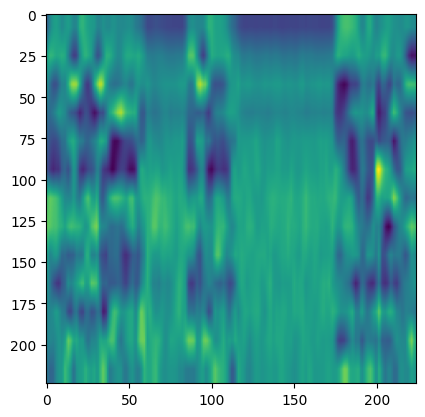

In [32]:
plt.imshow(np.transpose(a[0].to('cpu').numpy(), [1, 2, 0]))

Visualize a random sample from the dataloader to verify it looks as expected

In [33]:
random_sample = np.random.randint(0, 2300)
sample_mfcc, sample_speaker = mfcc_dataset_train.__getitem__(random_sample)

print(sample_mfcc.shape, sample_speaker.shape)

mfcc_arr = sample_mfcc.to('cpu').numpy().reshape(13, 126)
plt.figure()
plt.imshow(mfcc_arr)
plt.figure(figsize=(12, 8))
for i in range(mfcc_arr.shape[0]):
    plt.plot(mfcc_arr[i,:], label=f"channel_{i}")
plt.legend()

torch.Size([1, 224, 224]) torch.Size([])


C:\Users\David\AppData\Local\Temp\ipykernel_14792\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


ValueError: cannot reshape array of size 50176 into shape (13,126)

## Model Training

In [ ]:
def evaluate(model, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_epoch = 0
    val_acc = []

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            mfcc, speakers = data
            outputs = model(mfcc)

            loss = criterion(outputs, speakers)
            total_loss += loss.item()
            total_epoch += len(speakers)
            val_acc.append(get_accuracy(model, loader))

        loss = float(total_loss) / (i + 1)
        val_acc = np.mean(val_acc)
    return loss, val_acc

def get_accuracy(model, dataloader):
    #select index with maximum prediction score
    correct = 0
    total = 0
    for data in dataloader:
        mfcc, labels = data
        output = model(mfcc)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

def train_model(model, train_loader, val_loader, batch_size, num_epochs, criterion, optimizer, print_every=2, plot_loss=True):
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
        
    if torch.cuda.is_available():
        model = model.to(torch.device('cuda:0'))
    
    for epoch in tqdm(range(num_epochs)): 
        total_train_loss = 0.0
        total_epoch = 0
        total_train_acc = []
        correct = 0.0
        total = 0.0
        
        model.train()
        
        for i, data in enumerate(train_loader):
            mfcc, speakers = data
                        
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass, backward pass, and optimize
            outputs = model(mfcc)
            loss = criterion(outputs, speakers)
            loss.backward()
            optimizer.step()
            
            # Calculate the statistics
            total_train_loss += loss.item()
            total_epoch += len(speakers)
            total_train_acc.append(get_accuracy(model, train_loader))
            
        model.eval()
        train_loss[epoch] = float(total_train_loss) / (i+1)
        train_acc[epoch] = np.mean(total_train_acc)        
        val_loss[epoch], val_acc[epoch] = evaluate(model, val_loader, criterion)
        
        if epoch % print_every == 0:    
            print(f"Epoch {epoch}: \n \
            Train loss {train_loss[epoch]:.3f} | Val loss {val_loss[epoch]:.3f} \n \
            Train acc {train_acc[epoch]:.3f} | Val acc {val_acc[epoch]:.3f} \n")
            
            
    if plot_loss:
        n = len(train_loss) # number of epochs
        plt.figure()
        plt.title("Train vs Validation Loss")
        plt.plot(range(1,n+1), train_loss, label="Train")
        plt.plot(range(1,n+1), val_loss, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend(loc='best')

        plt.figure()
        plt.title("Train vs Validation Accuracy")
        plt.plot(range(1,n+1), train_acc, label="Train")
        plt.plot(range(1,n+1), val_acc, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend(loc='best')   

In [ ]:
class FCN(nn.Module):
    def __init__(self, input_layers, hidden_layers, output_size):
        super(FCN, self).__init__()

        self.fc1 = nn.Linear(3 * 11 * 124, hidden_layers)
        self.fc2 = nn.Linear(hidden_layers, output_size)

    def forward(self, x):
        x = x.float()
        x = x.view(-1, 13 * 126)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
class CNN(nn.Module):
    def __init__(self, hidden_layers, output_size):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(1 * 224 * 224, hidden_layers)
        self.fc2 = nn.Linear(hidden_layers, output_size)

    def forward(self, x):
        x = x.float()
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = x.view(-1, 1 * 224 * 224)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# model hyperparameters
hidden_layers = 300
output_size = len(np.unique(df_spkr['speaker_id']))
lr = 0.01
momentum = 0.9
num_epochs = 30

model = CNN(hidden_layers=hidden_layers, output_size=output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)#, momentum=momentum)
num_epochs = num_epochs

  3%|▎         | 1/30 [01:18<37:46, 78.15s/it]

Epoch 0: 
             Train loss 5.628 | Val loss 5.420 
             Train acc 0.011 | Val acc 0.015 



  7%|▋         | 2/30 [02:17<31:12, 66.86s/it]

Epoch 1: 
             Train loss 4.880 | Val loss 4.115 
             Train acc 0.061 | Val acc 0.091 



 10%|█         | 3/30 [03:20<29:27, 65.47s/it]

Epoch 2: 
             Train loss 3.540 | Val loss 3.272 
             Train acc 0.219 | Val acc 0.224 



 13%|█▎        | 4/30 [04:19<27:10, 62.72s/it]

Epoch 3: 
             Train loss 2.546 | Val loss 2.801 
             Train acc 0.397 | Val acc 0.304 



 17%|█▋        | 5/30 [05:19<25:42, 61.68s/it]

Epoch 4: 
             Train loss 1.994 | Val loss 2.543 
             Train acc 0.512 | Val acc 0.373 



 20%|██        | 6/30 [06:19<24:27, 61.16s/it]

Epoch 5: 
             Train loss 1.552 | Val loss 2.381 
             Train acc 0.614 | Val acc 0.419 



 23%|██▎       | 7/30 [07:16<22:55, 59.81s/it]

Epoch 6: 
             Train loss 1.277 | Val loss 2.343 
             Train acc 0.678 | Val acc 0.445 



 27%|██▋       | 8/30 [08:13<21:38, 59.02s/it]

Epoch 7: 
             Train loss 1.034 | Val loss 2.488 
             Train acc 0.735 | Val acc 0.445 



 30%|███       | 9/30 [09:10<20:26, 58.41s/it]

Epoch 8: 
             Train loss 0.878 | Val loss 2.582 
             Train acc 0.771 | Val acc 0.446 



 33%|███▎      | 10/30 [10:09<19:31, 58.58s/it]

Epoch 9: 
             Train loss 0.843 | Val loss 2.651 
             Train acc 0.787 | Val acc 0.437 



 37%|███▋      | 11/30 [11:08<18:32, 58.53s/it]

Epoch 10: 
             Train loss 0.690 | Val loss 2.892 
             Train acc 0.815 | Val acc 0.444 



 40%|████      | 12/30 [12:13<18:09, 60.51s/it]

Epoch 11: 
             Train loss 0.638 | Val loss 2.822 
             Train acc 0.836 | Val acc 0.437 



 43%|████▎     | 13/30 [13:11<16:54, 59.69s/it]

Epoch 12: 
             Train loss 0.476 | Val loss 3.320 
             Train acc 0.879 | Val acc 0.431 



 47%|████▋     | 14/30 [14:10<15:54, 59.68s/it]

Epoch 13: 
             Train loss 0.412 | Val loss 3.668 
             Train acc 0.899 | Val acc 0.438 



 50%|█████     | 15/30 [15:09<14:49, 59.31s/it]

Epoch 14: 
             Train loss 0.341 | Val loss 3.759 
             Train acc 0.908 | Val acc 0.431 



 53%|█████▎    | 16/30 [16:08<13:49, 59.22s/it]

Epoch 15: 
             Train loss 0.289 | Val loss 3.915 
             Train acc 0.930 | Val acc 0.434 



 57%|█████▋    | 17/30 [17:19<13:35, 62.74s/it]

Epoch 16: 
             Train loss 0.303 | Val loss 4.456 
             Train acc 0.918 | Val acc 0.421 



 60%|██████    | 18/30 [18:21<12:31, 62.59s/it]

Epoch 17: 
             Train loss 0.314 | Val loss 4.194 
             Train acc 0.919 | Val acc 0.417 



 63%|██████▎   | 19/30 [19:20<11:16, 61.52s/it]

Epoch 18: 
             Train loss 0.242 | Val loss 4.456 
             Train acc 0.937 | Val acc 0.428 



 67%|██████▋   | 20/30 [20:21<10:14, 61.40s/it]

Epoch 19: 
             Train loss 0.221 | Val loss 5.158 
             Train acc 0.936 | Val acc 0.383 



 70%|███████   | 21/30 [21:20<09:05, 60.57s/it]

Epoch 20: 
             Train loss 0.184 | Val loss 4.874 
             Train acc 0.958 | Val acc 0.434 



 73%|███████▎  | 22/30 [22:18<07:59, 59.99s/it]

Epoch 21: 
             Train loss 0.188 | Val loss 5.180 
             Train acc 0.946 | Val acc 0.417 



 77%|███████▋  | 23/30 [23:21<07:05, 60.85s/it]

Epoch 22: 
             Train loss 0.177 | Val loss 5.368 
             Train acc 0.950 | Val acc 0.427 



 80%|████████  | 24/30 [24:26<06:12, 62.02s/it]

Epoch 23: 
             Train loss 0.164 | Val loss 5.400 
             Train acc 0.953 | Val acc 0.411 



 83%|████████▎ | 25/30 [25:29<05:11, 62.24s/it]

Epoch 24: 
             Train loss 0.180 | Val loss 5.557 
             Train acc 0.954 | Val acc 0.412 



 87%|████████▋ | 26/30 [26:28<04:05, 61.26s/it]

Epoch 25: 
             Train loss 0.123 | Val loss 5.377 
             Train acc 0.968 | Val acc 0.418 



 90%|█████████ | 27/30 [27:25<03:00, 60.08s/it]

Epoch 26: 
             Train loss 0.122 | Val loss 5.813 
             Train acc 0.972 | Val acc 0.426 



 93%|█████████▎| 28/30 [28:23<01:58, 59.42s/it]

Epoch 27: 
             Train loss 0.161 | Val loss 6.993 
             Train acc 0.949 | Val acc 0.400 



 97%|█████████▋| 29/30 [29:21<00:59, 59.07s/it]

Epoch 28: 
             Train loss 0.191 | Val loss 5.795 
             Train acc 0.949 | Val acc 0.415 



100%|██████████| 30/30 [30:20<00:00, 60.70s/it]

Epoch 29: 
             Train loss 0.110 | Val loss 5.711 
             Train acc 0.973 | Val acc 0.416 



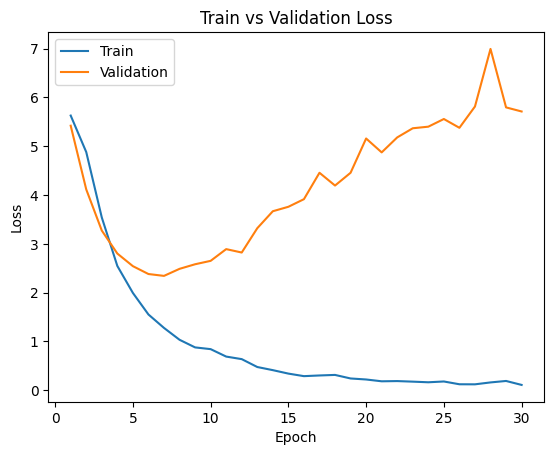

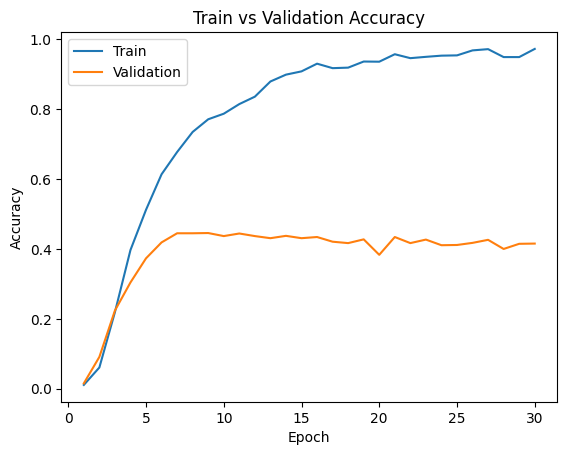

In [ ]:
# CNN model 1
train_model(model, train_loader, val_loader, batch_size, num_epochs, criterion, optimizer, print_every=1)

  3%|▎         | 1/30 [01:50<53:29, 110.66s/it]

Epoch 0: 
             Train loss 57.333 | Val loss 28.429 
             Train acc 0.004 | Val acc 0.003 



  7%|▋         | 2/30 [03:22<46:27, 99.57s/it] 

Epoch 1: 
             Train loss 14.752 | Val loss 5.569 
             Train acc 0.004 | Val acc 0.004 



 10%|█         | 3/30 [04:42<40:50, 90.78s/it]

Epoch 2: 
             Train loss 5.563 | Val loss 5.536 
             Train acc 0.004 | Val acc 0.005 



 13%|█▎        | 4/30 [05:42<34:04, 78.62s/it]

Epoch 3: 
             Train loss 5.541 | Val loss 5.527 
             Train acc 0.004 | Val acc 0.004 



 17%|█▋        | 5/30 [06:39<29:31, 70.87s/it]

Epoch 4: 
             Train loss 5.535 | Val loss 5.524 
             Train acc 0.004 | Val acc 0.005 



 20%|██        | 6/30 [07:36<26:25, 66.08s/it]

Epoch 5: 
             Train loss 5.533 | Val loss 5.521 
             Train acc 0.004 | Val acc 0.004 



 23%|██▎       | 7/30 [08:35<24:23, 63.62s/it]

Epoch 6: 
             Train loss 5.532 | Val loss 5.520 
             Train acc 0.004 | Val acc 0.004 



 27%|██▋       | 8/30 [09:39<23:21, 63.71s/it]

Epoch 7: 
             Train loss 5.530 | Val loss 5.522 
             Train acc 0.004 | Val acc 0.004 



 30%|███       | 9/30 [10:52<23:23, 66.81s/it]

Epoch 8: 
             Train loss 5.530 | Val loss 5.518 
             Train acc 0.004 | Val acc 0.004 



 33%|███▎      | 10/30 [12:28<25:16, 75.82s/it]

Epoch 9: 
             Train loss 5.529 | Val loss 5.520 
             Train acc 0.004 | Val acc 0.004 



 37%|███▋      | 11/30 [14:00<25:34, 80.77s/it]

Epoch 10: 
             Train loss 5.530 | Val loss 5.520 
             Train acc 0.004 | Val acc 0.005 



 40%|████      | 12/30 [15:13<23:27, 78.22s/it]

Epoch 11: 
             Train loss 5.530 | Val loss 5.520 
             Train acc 0.004 | Val acc 0.004 



 43%|████▎     | 13/30 [16:25<21:37, 76.33s/it]

Epoch 12: 
             Train loss 5.529 | Val loss 5.520 
             Train acc 0.004 | Val acc 0.005 



 47%|████▋     | 14/30 [17:44<20:33, 77.12s/it]

Epoch 13: 
             Train loss 5.531 | Val loss 5.518 
             Train acc 0.004 | Val acc 0.004 



 50%|█████     | 15/30 [19:55<23:21, 93.47s/it]

Epoch 14: 
             Train loss 5.529 | Val loss 5.520 
             Train acc 0.004 | Val acc 0.004 



 53%|█████▎    | 16/30 [21:31<21:57, 94.13s/it]

Epoch 15: 
             Train loss 5.528 | Val loss 5.521 
             Train acc 0.004 | Val acc 0.005 



 57%|█████▋    | 17/30 [22:44<19:04, 88.02s/it]

Epoch 16: 
             Train loss 5.530 | Val loss 5.520 
             Train acc 0.004 | Val acc 0.004 



 60%|██████    | 18/30 [24:04<17:05, 85.49s/it]

Epoch 17: 
             Train loss 5.529 | Val loss 5.520 
             Train acc 0.004 | Val acc 0.004 



 63%|██████▎   | 19/30 [25:13<14:45, 80.53s/it]

Epoch 18: 
             Train loss 5.529 | Val loss 5.518 
             Train acc 0.004 | Val acc 0.004 



 67%|██████▋   | 20/30 [26:46<14:01, 84.18s/it]

Epoch 19: 
             Train loss 5.529 | Val loss 5.520 
             Train acc 0.004 | Val acc 0.004 



 70%|███████   | 21/30 [27:48<11:37, 77.55s/it]

Epoch 20: 
             Train loss 5.530 | Val loss 5.519 
             Train acc 0.004 | Val acc 0.004 



 73%|███████▎  | 22/30 [28:48<09:38, 72.33s/it]

Epoch 21: 
             Train loss 5.529 | Val loss 5.520 
             Train acc 0.004 | Val acc 0.005 



 77%|███████▋  | 23/30 [29:52<08:08, 69.78s/it]

Epoch 22: 
             Train loss 5.529 | Val loss 5.520 
             Train acc 0.004 | Val acc 0.004 



 80%|████████  | 24/30 [30:59<06:54, 69.07s/it]

Epoch 23: 
             Train loss 5.531 | Val loss 5.518 
             Train acc 0.004 | Val acc 0.004 



 83%|████████▎ | 25/30 [31:56<05:27, 65.42s/it]

Epoch 24: 
             Train loss 5.529 | Val loss 5.518 
             Train acc 0.004 | Val acc 0.004 



 87%|████████▋ | 26/30 [32:54<04:12, 63.03s/it]

Epoch 25: 
             Train loss 5.529 | Val loss 5.518 
             Train acc 0.004 | Val acc 0.004 



 90%|█████████ | 27/30 [33:52<03:05, 61.73s/it]

Epoch 26: 
             Train loss 5.530 | Val loss 5.518 
             Train acc 0.004 | Val acc 0.005 



 93%|█████████▎| 28/30 [34:51<02:01, 60.97s/it]

Epoch 27: 
             Train loss 5.530 | Val loss 5.520 
             Train acc 0.004 | Val acc 0.004 



 97%|█████████▋| 29/30 [35:50<01:00, 60.19s/it]

Epoch 28: 
             Train loss 5.531 | Val loss 5.519 
             Train acc 0.004 | Val acc 0.005 



100%|██████████| 30/30 [36:52<00:00, 73.75s/it]

Epoch 29: 
             Train loss 5.530 | Val loss 5.521 
             Train acc 0.004 | Val acc 0.005 



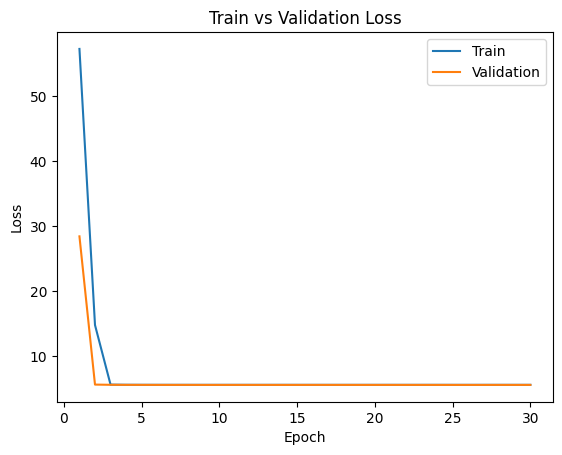

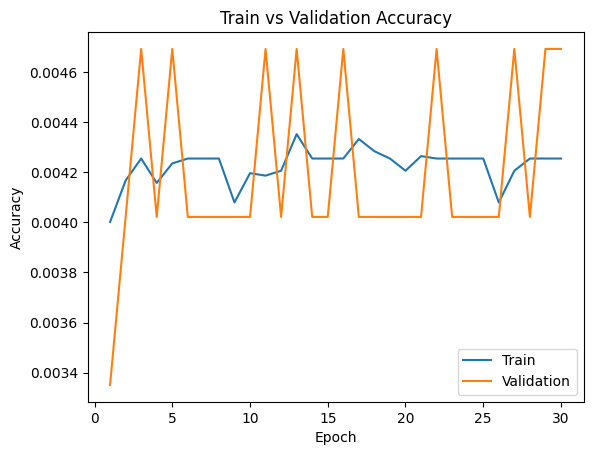

In [ ]:
# CNN 2

# model hyperparameters
hidden_layers = 500
output_size = len(np.unique(df_spkr['speaker_id']))
lr = 0.05
momentum = 0.9
num_epochs = 30

model = CNN(hidden_layers=hidden_layers, output_size=output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)#, momentum=momentum)
num_epochs = num_epochs

train_model(model, train_loader, val_loader, batch_size, num_epochs, criterion, optimizer, print_every=1)

  5%|▌         | 1/20 [01:07<21:31, 67.97s/it]

Epoch 0: 
             Train loss 5.232 | Val loss 4.142 
             Train acc 0.058 | Val acc 0.114 



 10%|█         | 2/20 [02:05<18:32, 61.81s/it]

Epoch 1: 
             Train loss 3.048 | Val loss 3.264 
             Train acc 0.399 | Val acc 0.220 



 15%|█▌        | 3/20 [03:02<16:52, 59.56s/it]

Epoch 2: 
             Train loss 1.595 | Val loss 3.477 
             Train acc 0.688 | Val acc 0.231 



 20%|██        | 4/20 [03:57<15:25, 57.84s/it]

Epoch 3: 
             Train loss 0.793 | Val loss 4.113 
             Train acc 0.860 | Val acc 0.236 



 25%|██▌       | 5/20 [04:52<14:13, 56.87s/it]

Epoch 4: 
             Train loss 0.322 | Val loss 5.350 
             Train acc 0.941 | Val acc 0.243 



 30%|███       | 6/20 [05:47<13:08, 56.29s/it]

Epoch 5: 
             Train loss 0.183 | Val loss 5.697 
             Train acc 0.968 | Val acc 0.252 



 35%|███▌      | 7/20 [06:46<12:22, 57.15s/it]

Epoch 6: 
             Train loss 0.140 | Val loss 5.887 
             Train acc 0.975 | Val acc 0.249 



 40%|████      | 8/20 [07:43<11:23, 56.93s/it]

Epoch 7: 
             Train loss 0.126 | Val loss 5.909 
             Train acc 0.977 | Val acc 0.219 



 45%|████▌     | 9/20 [08:38<10:21, 56.49s/it]

Epoch 8: 
             Train loss 0.083 | Val loss 6.537 
             Train acc 0.985 | Val acc 0.242 



 50%|█████     | 10/20 [09:35<09:26, 56.61s/it]

Epoch 9: 
             Train loss 0.077 | Val loss 6.552 
             Train acc 0.986 | Val acc 0.239 



 55%|█████▌    | 11/20 [10:31<08:26, 56.28s/it]

Epoch 10: 
             Train loss 0.079 | Val loss 6.203 
             Train acc 0.986 | Val acc 0.231 



 60%|██████    | 12/20 [11:29<07:34, 56.83s/it]

Epoch 11: 
             Train loss 0.039 | Val loss 7.084 
             Train acc 0.992 | Val acc 0.229 



 65%|██████▌   | 13/20 [12:21<06:27, 55.32s/it]

Epoch 12: 
             Train loss 0.071 | Val loss 6.211 
             Train acc 0.989 | Val acc 0.230 



 70%|███████   | 14/20 [17:06<12:29, 124.87s/it]

Epoch 13: 
             Train loss 0.031 | Val loss 6.785 
             Train acc 0.995 | Val acc 0.245 



 75%|███████▌  | 15/20 [18:16<09:01, 108.22s/it]

Epoch 14: 
             Train loss 0.025 | Val loss 7.066 
             Train acc 0.995 | Val acc 0.228 



 80%|████████  | 16/20 [19:25<06:26, 96.52s/it] 

Epoch 15: 
             Train loss 0.023 | Val loss 6.726 
             Train acc 0.997 | Val acc 0.232 



 85%|████████▌ | 17/20 [20:38<04:28, 89.36s/it]

Epoch 16: 
             Train loss 0.025 | Val loss 6.880 
             Train acc 0.997 | Val acc 0.248 



 90%|█████████ | 18/20 [21:47<02:46, 83.39s/it]

Epoch 17: 
             Train loss 0.034 | Val loss 6.612 
             Train acc 0.995 | Val acc 0.223 



 95%|█████████▌| 19/20 [24:07<01:40, 100.40s/it]

Epoch 18: 
             Train loss 0.027 | Val loss 7.162 
             Train acc 0.994 | Val acc 0.222 



100%|██████████| 20/20 [25:49<00:00, 77.48s/it] 

Epoch 19: 
             Train loss 0.022 | Val loss 7.143 
             Train acc 0.997 | Val acc 0.224 



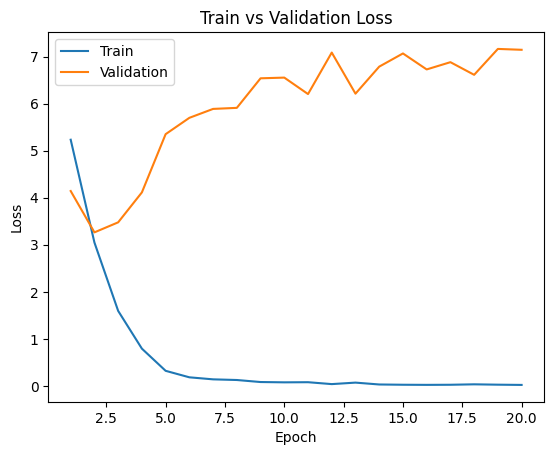

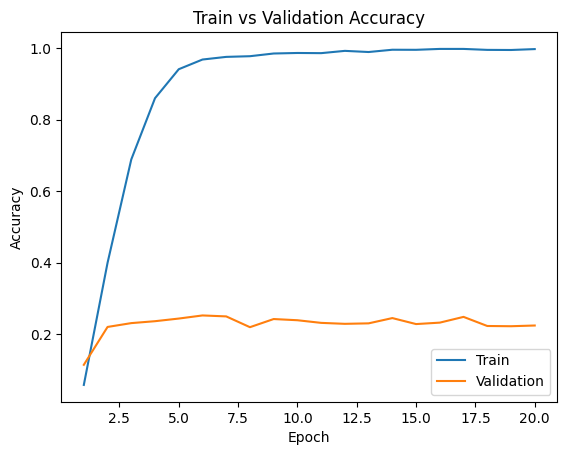

In [ ]:
# CNN 3

# model hyperparameters
hidden_layers = 150
output_size = len(np.unique(df_spkr['speaker_id']))
lr = 0.01
momentum = 0.9
num_epochs = 20

model = CNN(hidden_layers=hidden_layers, output_size=output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)#, momentum=momentum)
num_epochs = num_epochs

train_model(model, train_loader, val_loader, batch_size, num_epochs, criterion, optimizer, print_every=1)

Note: the test model and the test dataset will be side aside to the end of the project, to evaluate the overall accuracy of the best model. Therefore, the team will not use the test model or test dataset for the progress report. 

In [ ]:
def test_model(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            mfcc, speakers = data
            outputs = model(mfcc)
            _, predicted = torch.max(outputs.data, 1)
            total += speakers.size(0)
            correct += (predicted == speakers).sum().item()

    print(f'Accuracy: {100 * correct // total} %')

In [ ]:
test_model(model, test_loader)

In [ ]:
speaker_dict # {original_speaker_id, encoded_speaker_id}

In [ ]:
classes = [str(speaker_id) for speaker_id in range(len(np.unique(df_spkr['speaker_id'])))]
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

for mfcc, speakers in test_loader:
    outputs = model(mfcc)
    _, predicted = torch.max(outputs.data, 1)
    # print(f"predicted: {predicted}, actual: {speakers}")
    for label, prediction in zip(speakers, predicted):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
    
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

## AlexNet

In [ ]:
alexnet = models.alexnet(pretrained=True)

c:\Users\David\anaconda3\envs\speaker-recon\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\David\anaconda3\envs\speaker-recon\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Freeze model parameters
for param in alexnet.parameters():
    param.requires_grad = False

In [ ]:
alexnet.features[0] = nn.Conv2d(1, 64, kernel_size=(1,1))

In [ ]:
#Modify the final output layer
alexnet.classifier.add_module("6",nn.Linear(4096, 500))
alexnet.classifier.add_module("7",nn.LeakyReLU())
alexnet.classifier.add_module("8",nn.Linear(500, len(np.unique(df_spkr['speaker_id']))))
# alexnet.classifier.add_module("9", nn.LogSoftmax(dim = 1))
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inpla

In [44]:
subset_train_size, subset_val_size = train_set.__len__(), val_set.__len__()

In [46]:
print(subset_train_size)
print(subset_val_size)

4466
1492


In [30]:
# Define Optimizer and Loss Function

def train_and_validate(model, epochs=25, batch_size = 10, lr=1e-3):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0
    loss_criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)
                
                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/subset_train_size 
        avg_train_acc = train_acc/subset_train_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/subset_val_size 
        avg_valid_acc = valid_acc/subset_val_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        #torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history

In [ ]:
alexnet = alexnet.to('cuda')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


trained_model, history = train_and_validate(alexnet, epochs=25, batch_size = 64, lr=1e-3)

Epoch: 1/25


C:\Users\David\AppData\Local\Temp\ipykernel_26744\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


Epoch : 001, Training: Loss: 2.1066, Accuracy: 40.9539%, 
		Validation : Loss : 2.0094, Accuracy: 47.4531%, Time: 18.7861s
Epoch: 2/25
Epoch : 002, Training: Loss: 2.0230, Accuracy: 43.7304%, 
		Validation : Loss : 2.0238, Accuracy: 46.1126%, Time: 17.6096s
Epoch: 3/25
Epoch : 003, Training: Loss: 1.9910, Accuracy: 44.7380%, 
		Validation : Loss : 1.9716, Accuracy: 47.7882%, Time: 15.8001s
Epoch: 4/25
Epoch : 004, Training: Loss: 1.9996, Accuracy: 43.4169%, 
		Validation : Loss : 1.9632, Accuracy: 47.1180%, Time: 14.7827s
Epoch: 5/25
Epoch : 005, Training: Loss: 2.0006, Accuracy: 43.7528%, 
		Validation : Loss : 1.9499, Accuracy: 47.0509%, Time: 14.6571s
Epoch: 6/25
Epoch : 006, Training: Loss: 1.9662, Accuracy: 45.2978%, 
		Validation : Loss : 1.9414, Accuracy: 47.7882%, Time: 14.6466s
Epoch: 7/25
Epoch : 007, Training: Loss: 1.9639, Accuracy: 44.7604%, 
		Validation : Loss : 1.9292, Accuracy: 48.2574%, Time: 14.9964s
Epoch: 8/25
Epoch : 008, Training: Loss: 1.9154, Accuracy: 46.1935%

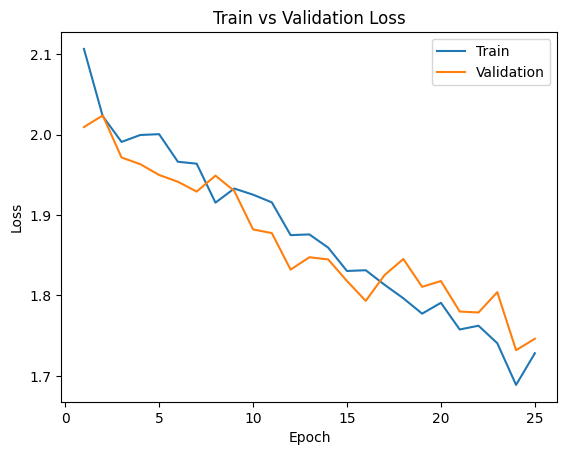

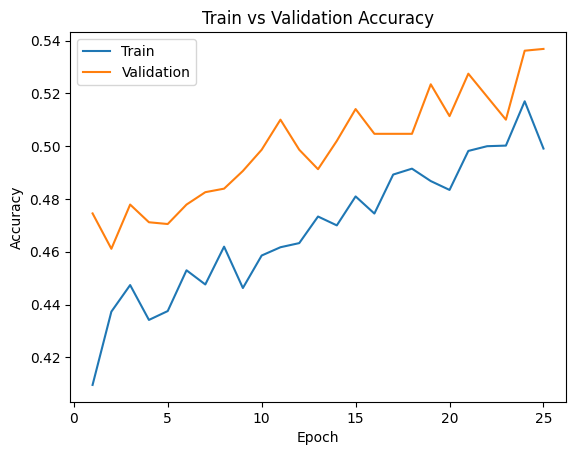

In [ ]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []
ep = []
i = 0
for tloss,vloss, tacc, vacc in history:
    train_acc.append(tacc)
    val_acc.append(vacc)
    train_loss.append(tloss)
    val_loss.append(vloss)
    ep.append(i)
    i += 1


n = len(train_loss) # number of epochs
plt.figure()
plt.title("Train vs Validation Loss")
plt.plot(range(1,n+1), train_loss, label="Train")
plt.plot(range(1,n+1), val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
# plt.show()

plt.figure()
plt.title("Train vs Validation Accuracy")
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')

In [ ]:
#TODO: Ran alexnet 3 times for the report [WILL]

AlexNet #2:
Single FC output layer with Softmax activation function

In [47]:
alexnet2 = models.alexnet(pretrained=False)
# Freeze model parameters
#for param in alexnet2.parameters():
#    param.requires_grad = False
#Modify the model structure
# Input layer to 1 channel for one channel img    
alexnet2.features[0] = nn.Conv2d(1, 64, kernel_size=(1,1))
#Modify the final output layer
alexnet2.classifier.add_module("6",nn.Linear(4096, len(np.unique(df_spkr['speaker_id']))))
alexnet2.classifier.add_module("7", nn.LogSoftmax(dim = 1))
alexnet2

c:\Users\David\anaconda3\envs\speaker-recon\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\David\anaconda3\envs\speaker-recon\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inpla

In [48]:
alexnet2 = alexnet2.to('cuda')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


trained_model, history = train_and_validate(alexnet2, epochs=55, batch_size = 64, lr=1e-4)

Epoch: 1/55


C:\Users\David\AppData\Local\Temp\ipykernel_28912\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


Epoch : 001, Training: Loss: 5.5270, Accuracy: 0.2687%, 
		Validation : Loss : 5.5088, Accuracy: 1.2735%, Time: 22.5124s
Epoch: 2/55
Epoch : 002, Training: Loss: 4.9555, Accuracy: 2.9109%, 
		Validation : Loss : 4.1114, Accuracy: 8.7131%, Time: 21.2067s
Epoch: 3/55
Epoch : 003, Training: Loss: 3.7964, Accuracy: 12.1585%, 
		Validation : Loss : 3.2421, Accuracy: 20.9786%, Time: 21.2448s
Epoch: 4/55
Epoch : 004, Training: Loss: 2.9999, Accuracy: 25.1903%, 
		Validation : Loss : 2.7720, Accuracy: 28.2842%, Time: 20.7288s
Epoch: 5/55
Epoch : 005, Training: Loss: 2.5914, Accuracy: 32.1093%, 
		Validation : Loss : 2.4759, Accuracy: 33.0429%, Time: 21.2873s
Epoch: 6/55
Epoch : 006, Training: Loss: 2.2206, Accuracy: 40.4165%, 
		Validation : Loss : 2.3087, Accuracy: 40.0804%, Time: 21.1432s
Epoch: 7/55
Epoch : 007, Training: Loss: 1.8588, Accuracy: 48.1415%, 
		Validation : Loss : 1.9650, Accuracy: 47.1180%, Time: 19.9937s
Epoch: 8/55
Epoch : 008, Training: Loss: 1.5297, Accuracy: 57.1205%, 
	

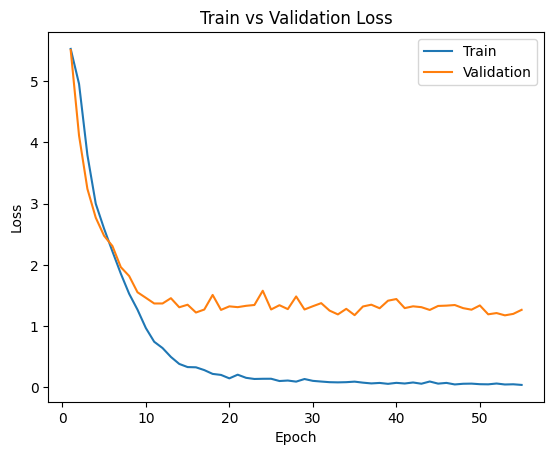

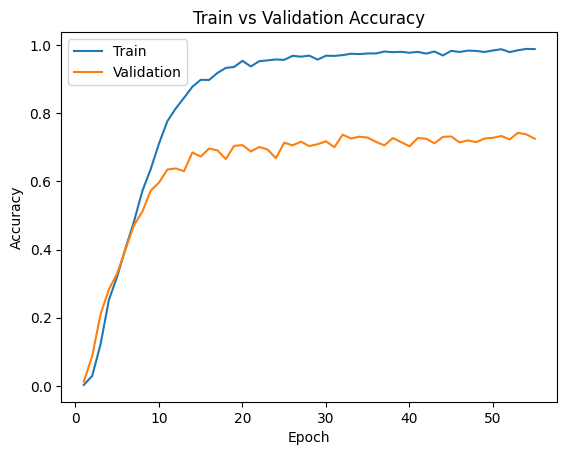

In [49]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []
ep = []
i = 0
for tloss,vloss, tacc, vacc in history:
    train_acc.append(tacc)
    val_acc.append(vacc)
    train_loss.append(tloss)
    val_loss.append(vloss)
    ep.append(i)
    i += 1


n = len(train_loss) # number of epochs
plt.figure()
plt.title("Train vs Validation Loss")
plt.plot(range(1,n+1), train_loss, label="Train")
plt.plot(range(1,n+1), val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
# plt.show()

plt.figure()
plt.title("Train vs Validation Accuracy")
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')

AlexNet #3: ReLU activation function between last two FC layers and Softmax at end

In [50]:
alexnet3 = models.alexnet(pretrained=False)
# Freeze model parameters
#for param in alexnet3.parameters():
#    param.requires_grad = False
#Modify the model structure
# Input layer to 1 channel for one channel img    
alexnet3.features[0] = nn.Conv2d(1, 64, kernel_size=(1,1))

#Modify the final output layer
alexnet3.classifier.add_module("6",nn.Linear(4096, 2048))
alexnet3.classifier.add_module("7",nn.ReLU())
alexnet3.classifier.add_module("8",nn.Linear(2048, len(np.unique(df_spkr['speaker_id']))))
alexnet3.classifier.add_module("9", nn.LogSoftmax(dim = 1))
alexnet3

c:\Users\David\anaconda3\envs\speaker-recon\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\David\anaconda3\envs\speaker-recon\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inpla

In [51]:
alexnet3 = alexnet3.to('cuda')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


trained_model, history = train_and_validate(alexnet3, epochs=35, batch_size = 64, lr=1e-4)

Epoch: 1/35


C:\Users\David\AppData\Local\Temp\ipykernel_28912\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


Epoch : 001, Training: Loss: 5.5268, Accuracy: 0.3135%, 
		Validation : Loss : 5.5220, Accuracy: 1.1394%, Time: 22.6395s
Epoch: 2/35
Epoch : 002, Training: Loss: 5.2669, Accuracy: 1.2539%, 
		Validation : Loss : 4.7554, Accuracy: 3.4853%, Time: 20.7033s
Epoch: 3/35
Epoch : 003, Training: Loss: 4.3185, Accuracy: 5.6426%, 
		Validation : Loss : 3.8537, Accuracy: 10.6568%, Time: 20.4616s
Epoch: 4/35
Epoch : 004, Training: Loss: 3.6370, Accuracy: 13.0990%, 
		Validation : Loss : 3.3344, Accuracy: 17.7614%, Time: 20.6888s
Epoch: 5/35
Epoch : 005, Training: Loss: 3.1072, Accuracy: 21.1151%, 
		Validation : Loss : 2.8981, Accuracy: 25.6032%, Time: 20.9885s
Epoch: 6/35
Epoch : 006, Training: Loss: 2.7335, Accuracy: 26.9145%, 
		Validation : Loss : 2.5479, Accuracy: 31.6354%, Time: 20.6638s
Epoch: 7/35
Epoch : 007, Training: Loss: 2.4628, Accuracy: 32.0869%, 
		Validation : Loss : 2.4070, Accuracy: 36.1260%, Time: 20.6628s
Epoch: 8/35
Epoch : 008, Training: Loss: 2.2325, Accuracy: 37.4384%, 
		

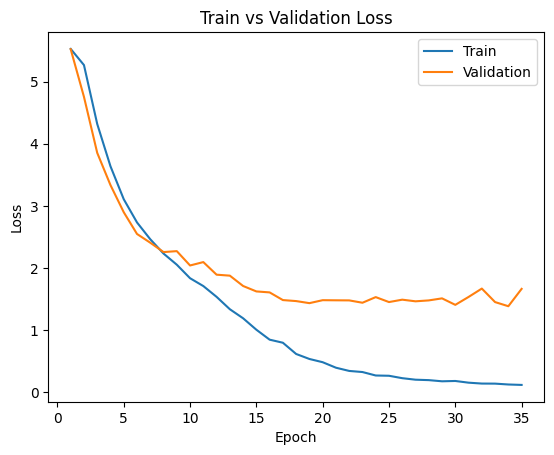

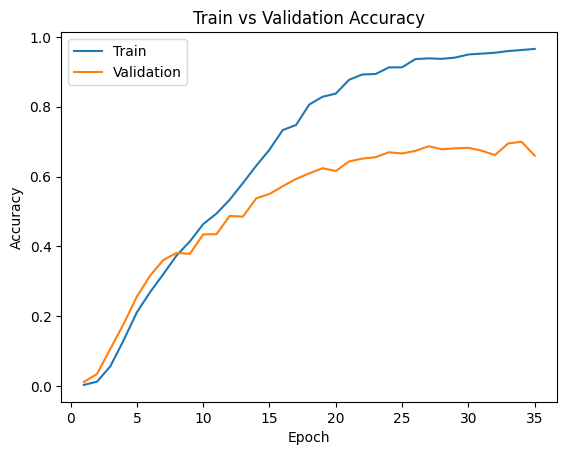

In [52]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []
ep = []
i = 0
for tloss,vloss, tacc, vacc in history:
    train_acc.append(tacc)
    val_acc.append(vacc)
    train_loss.append(tloss)
    val_loss.append(vloss)
    ep.append(i)
    i += 1


n = len(train_loss) # number of epochs
plt.figure()
plt.title("Train vs Validation Loss")
plt.plot(range(1,n+1), train_loss, label="Train")
plt.plot(range(1,n+1), val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
# plt.show()

plt.figure()
plt.title("Train vs Validation Accuracy")
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')

# FUTURE WORK
- Based on the current best accuracy, the team will re-validate the models with more datasets (other than librispeech)
- The team will implement automated hyper prameter tuning on the current best model to see if the accuracy will be acceptable. 
- If the accuracy is low, the team will try other architectures
- The team will set up a meeting with the professor or the TAs to get some feedback. 